# Spectral Counting (SpC) Analysis with R and edgeR

## Phil Wilmarth, OHSU

### February 2019

## Objectives and overview

This notebook will demonstrate using Jupyter notebooks, R, and edgeR to perform statistical analysis of a very large spectral counting study using a paired study design.

The notebook will:
- load libraries and set up the R session
- load the proteomics result file
- do some exploratory data analysis of starting data
- load data into edgeR data structures
- normalize the data
- compute trended variances
- perform a paired study design analysis using generalized linear models
- visualize the test results
- collect results into table and write to a file

---

## Dataset description

The data is from a [recent study](https://www.sciencedirect.com/science/article/pii/S0002939418301193) **(Ref-1)** where human retinal and choroidal endothelial cells were compared. The study was 5 donor eyes where retinal and choroidal cells were collected and cultured in a paired design. The cell lysates from each of the 10 cell cultures were profiled using large-scale separations with a fast-scanning linear ion trap. There were about half a million MS2 scans per sample for a dataset size of a little over 5 million. The data are available at the PRIDE archive ([PXD005972](https://www.ebi.ac.uk/pride/archive/projects/PXD005972)).

A few relevant files from the archive are present in the repository:

- analysis_overview.pptx - summary of the data analysis steps
- quant_protein_summary_8.txt - a grouped protein summary file
- edgeR_input.txt - data extracted from results file for edgeR analysis
- HCEC_HREC_quant_protein_summary_sprot.xlsx - final summary sheet
  - proteomics data from quant_protein_summary_8.txt
  - statistical results from edgeR
  - extra protein annotations

The goal here is to demonstrate edgeR **(Ref-2**) statistical testing that can be used for spectral counting **(Ref-3)** semi-quantitative experiments. The [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git) has some features for shotgun quantitation that we will be using. One is a protein grouping algorithm where highly homologous proteins (majority of peptides are shared with few unique peptides) are grouped together and the context for shared or unique peptides are updated accordingly. This extended parsimony logic is described in more detail [here](https://digitalcollections.ohsu.edu/concern/etds/c534fp149). The other feature is the splitting of shared peptide spectral counts based on relative unique peptide evidence.

> **1.** Smith JR, David LL, Appukuttan B, Wilmarth PA. Angiogenic and Immunologic Proteins Identified by Deep Proteomic Profiling of Human Retinal and Choroidal Vascular Endothelial Cells: Potential Targets for New Biologic Drugs. Am J Ophthalmol. 2018 Sep;193:197-229. doi: 10.1016/j.ajo.2018.03.020. Epub 2018 Mar17. PubMed PMID: 29559410; PubMed Central PMCID: PMC6109601.

> **2.** Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> **3.** Liu, H., Sadygov, R.G. and Yates, J.R., 2004. A model for random sampling and estimation of relative protein abundance in shotgun proteomics. Analytical chemistry, 76(14), pp.4193-4201.

---

## Load R libraries

In [1]:
library("tidyverse")
library("edgeR")
library("limma")
library("psych")
library("gridExtra")
library("stringr")
library("scales")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘edgeR’ was built under R version 3.5.2”Loading required package: limma
Warning message:
“package ‘limma’ was built under R version 3.5.1”Warning message:
“package ‘psych’ was built under R version 3.5.2”
Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘scales’

The following objects are masked from ‘package:psych’:

    alpha, rescale

The followi

## Data was prepped in Excel and exported to text file

The PAW pipeline, like most proteomics summary tables, has a lot more information that we need for the statistical analysis. Selecting the relevant columns from a large table is not too hard to do in R. Row filtering can be trickier. Decoy protein sequences are easy to drop. Common contaminant proteins can also be easier to identify. The situation for contaminants is often not so cut and dried. There are many ways to have contaminants in your samples that are not in any common contaminants database. 

I prefer to open the PAW summary files with Excel and then do some searches in the protein description column for things like "keratin", "albumin", "hemoglobin", "trypsin" and look at the data across samples to decide if I think any of the matches should go into the contaminants pile. I typically flag all proteins that I do not want to use in the quantitative analysis in a "Filter" column and leave the column blank for usable proteins. Then I can sort on the "Filter" column and move excluded proteins to the bottom of the table. I usually make a new table with the "keepers" that has just the protein accessions and the quantitative columns of interest.

---

## Set an appropriate average SpC cutoff

In any shotgun experiment, more things can be identified than can be quantified. For quantification we need data points for all samples. The "bottom" of the dataset will be proteins seen in one or a few samples. We will need to exclude those. How do we identify them? An ad hoc approach is to think about a two-condition experiment. These are often some sort of biomarker experiment so there might be a protein in one condition that is not in the other. A good rule of thumb for protein identification is two peptides per protein. That means that an SpC (spectral count) of 2 is at the detection limit. We want something above that lower limit to define a protein as confidently "present". A value of 5 is a good robust spectral count value; few decoy proteins have an SpC of 5 or greater. If we have 5 counts in one condition and no counts in the other, then an average SpC of 2.5 could be a good cutoff value. Do the data agree with this cutoff logic?

### Plot fraction of missing data points versus average SPC

We have 10 samples per protein. We can average the counts over the 10 samples for each protein. We can sort the count table by decreasing average SpC. For each row as we go down the table, we can count the number of cells with zero out of the total number of cells. At the top of the sorted table, we have no missing data and the missing fraction is always zero. As we get towards the bottom of the table, we will encounter zero count cells and the missing fraction will start to increase. 

I do not know how to program that in R (without some Google and Stack Overflow searching), but I do know how to do that in a couple of minutes in Excel. I created a text file with two columns: the average SpC and the missing fraction. Let's read that and plot the data.

Parsed with column specification:
cols(
  Ave = col_double(),
  FracMissing = col_double()
)


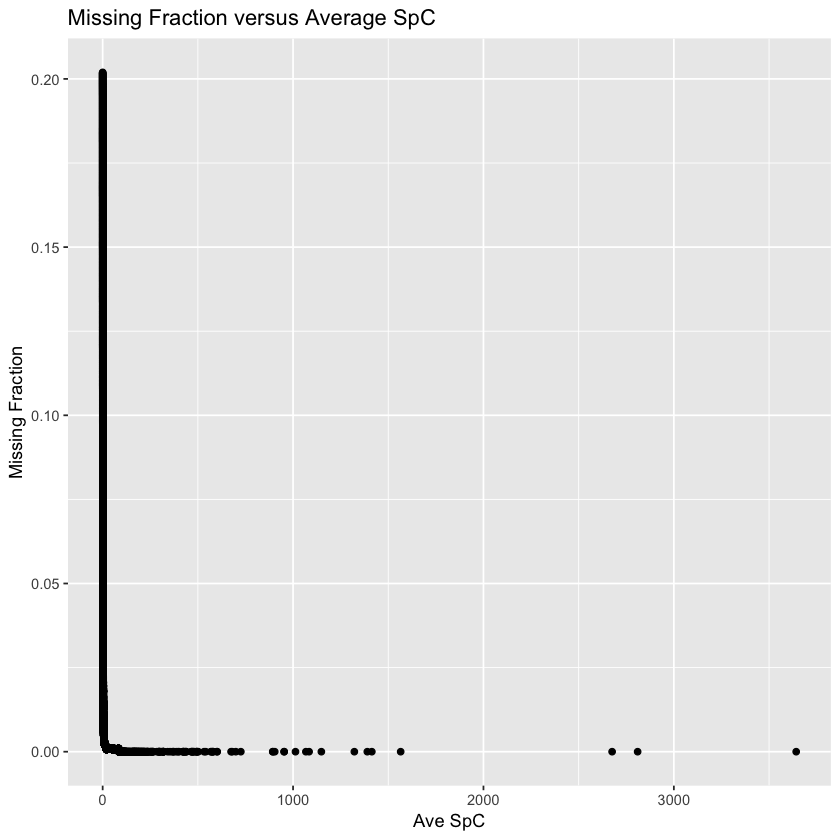

In [2]:
# read in the data
temp <- read_tsv("ave_missing.txt")

# make a basic plot
ggplot(temp, aes(x = Ave, y = FracMissing)) +
  geom_point() +
  ggtitle("Missing Fraction versus Average SpC") + 
  labs(x = "Ave SpC", y = "Missing Fraction")

### We have sharp increase in missing data at low average SPC

We need to expand the x-axis to see where the increase starts.

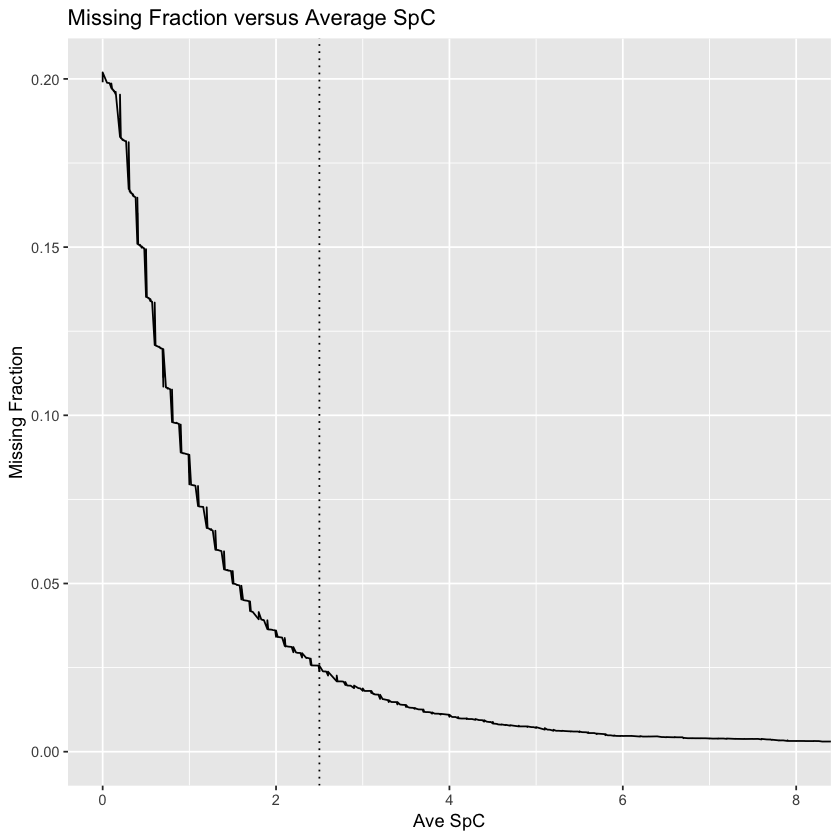

In [3]:
# expanded x-axis plot
ggplot(temp, aes(x = Ave, y = FracMissing)) +
  geom_line() + 
  coord_cartesian(xlim = c(0, 8)) +
  ggtitle("Missing Fraction versus Average SpC") + 
  labs( x = "Ave SpC", y = "Missing Fraction") + 
  geom_vline(xintercept = 2.5, linetype = "dotted")

### Cutoff of 2.5 looks pretty good

The fraction of data with missing values starts to rise at an average SpC of about 5.0. The missing data really starts to rise at average SpC values below 2.0. We usually want to cast a wide net for differential expression candidates in discovery experiments. A cutoff of 2.5 seems like a reasonable compromise. We might get some false positives near the cutoff, but those will be easy to catch manually later.

---

### Read in the data

The data exported in the `edgeR_input.txt` file excluded contaminants, decoys, and any proteins with an average SpC of less than 2.5. We will read that data in and separate the accessions from the count data.

In [4]:
# read in the prepped data
paw_spc <- read_tsv("edgeR_input.txt")

# save accessions in vector and remove from data table
accession <- paw_spc$Accession
paw_spc <- select(paw_spc, -Accession)
head(paw_spc)
nrow(paw_spc)

Parsed with column specification:
cols(
  Accession = col_character(),
  HCEC_189 = col_double(),
  HCEC_191 = col_double(),
  HCEC_194 = col_double(),
  HCEC_195 = col_double(),
  HCEC_199 = col_double(),
  HREC_189 = col_double(),
  HREC_191 = col_double(),
  HREC_194 = col_double(),
  HREC_195 = col_double(),
  HREC_199 = col_double()
)


HCEC_189,HCEC_191,HCEC_194,HCEC_195,HCEC_199,HREC_189,HREC_191,HREC_194,HREC_195,HREC_199
3088,3824,3157,2925,3940,4037,4838,3028,3096,4492
2166,2767,2443,2678,2913,2806,3413,2264,3443,3204
2233,2873,2163,2395,3388,2108,3405,1933,2768,3491
1400,1899,1964,1665,1966,1026,1662,1294,1512,1264
1207,1352,1525,1456,1549,1120,1544,1086,1787,1511
1237,1430,1457,1474,1417,1086,1700,1132,1647,1319


[1] 3454

The sample codes are HCEC for human choroidal endothelial cells and HREC for human retinal endothelial cells. The numbers are the 5 subject codes.

### Are we "losing out" by having a minimum SpC cutoff?

Depending a little on how you approach protein FDR, we have about 5000 protein IDs. After the 2.5 average SpC cutoff, we are down to 3454. Is this an issue? The answer is no. Counting things by the number of proteins can lead to erroneous conclusions. We have 10 samples and we can tally some things based on in how many samples were the proteins seen: all 10 out of the 10, any 9 out of the 10, etc. I did that in Excel and made a short table.

Parsed with column specification:
cols(
  InHowMany = col_double(),
  Proteins = col_double(),
  Fraction = col_double(),
  Measure = col_character()
)


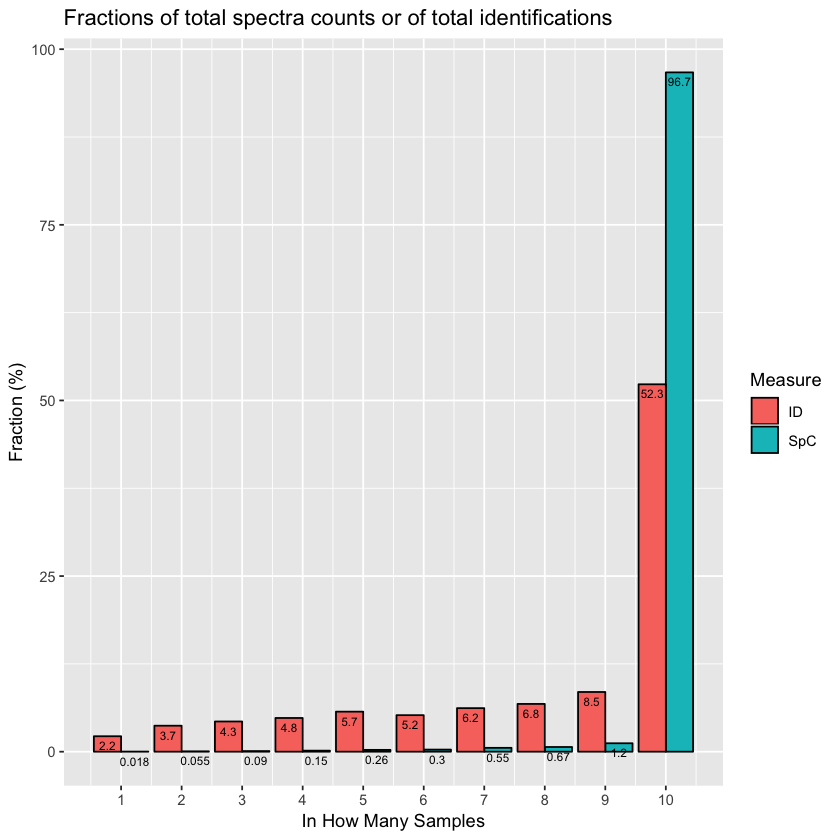

In [5]:
# read in short table
freq <- read_tsv("Fractions_SpC_ID.txt")

# make a bar plot to summarize the data
ggplot(freq, aes(InHowMany, Fraction, fill = Measure)) +
  geom_bar(stat = "identity", color = "black", position = position_dodge()) +
  geom_text(aes(label = Fraction), vjust = 1.6, color = "black",
            position = position_dodge(0.9), size = 2.5) +
  scale_x_continuous( breaks = 1:10) +
  ggtitle("Fractions of total spectra counts or of total identifications") +
  xlab("In How Many Samples") + ylab("Fraction (%)")

There are 2990 protein seen in all samples. That is about 60% of the identified proteins. However, those proteins account for 97% of all of the spectral counts. The 3454 proteins with an average SpC of 2.5 or greater account for 98.3% of the total spectral counts. 

These separations were pretty extensive, so we are capturing most of the proteome in each sample. That is why the "bulk" of the spectral counts are associated with the proteins seen in all samples. The proteins that are not seen in each sample are lower abundant proteins (those can be numerous) that do not add up to a very large fraction of the "total" proteome.

## Check choroidal and retinal sample similarities

This is a paired study design and we will use that in the statistical testing below. To get a sense of the data characteristics, we will compare the 5 choroidal samples to each other, and do the same for the 5 retinal samples. Multi-panel scatter plots are a nice method for exploratory data analysis. We will try linear and log scales. We have some zeros in the data, so we will add 1 for the log plots.

SL Factors:
 HCEC_189 -> 1.204953
 HCEC_191 -> 0.926952
 HCEC_194 -> 0.918081
 HCEC_195 -> 1.017995
 HCEC_199 -> 0.888918
 HREC_189 -> 1.248862
 HREC_191 -> 0.956278
 HREC_194 -> 1.155367
 HREC_195 -> 0.839545
 HREC_199 -> 1.008395


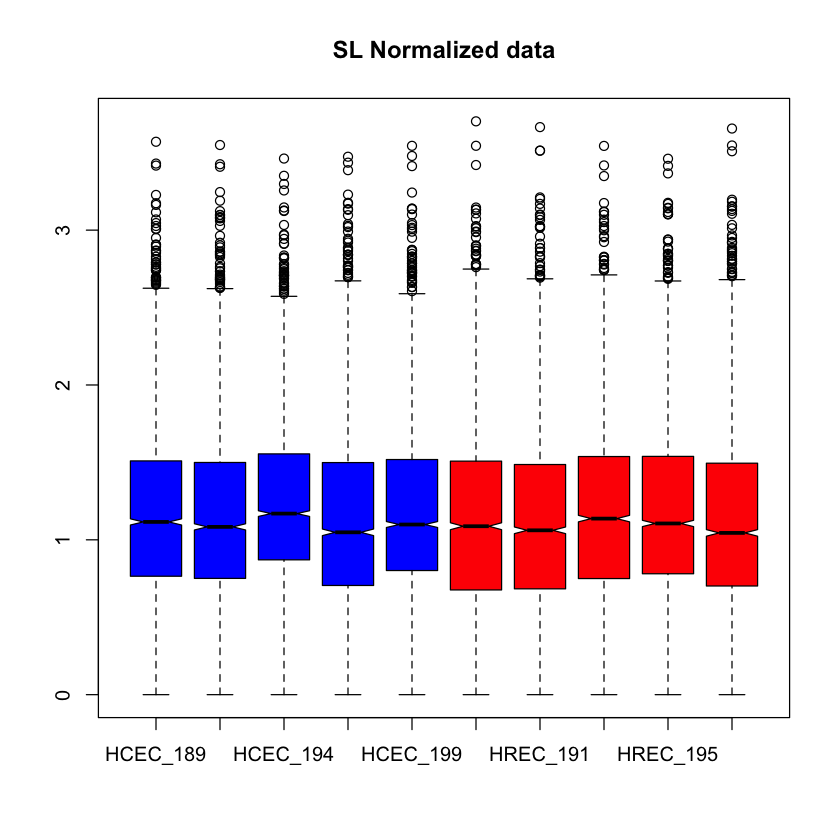

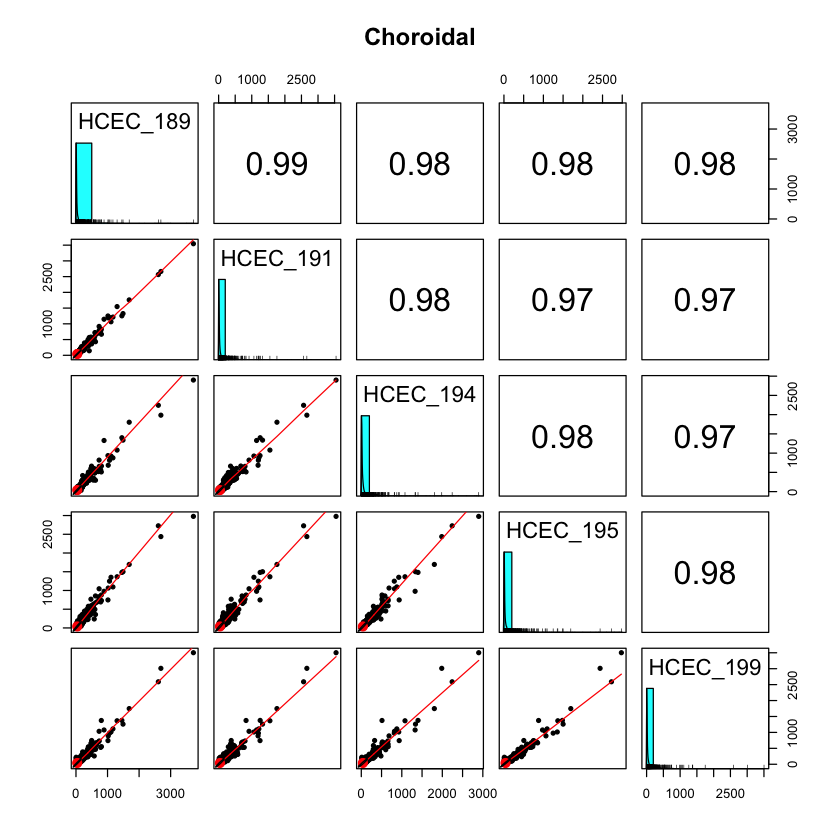

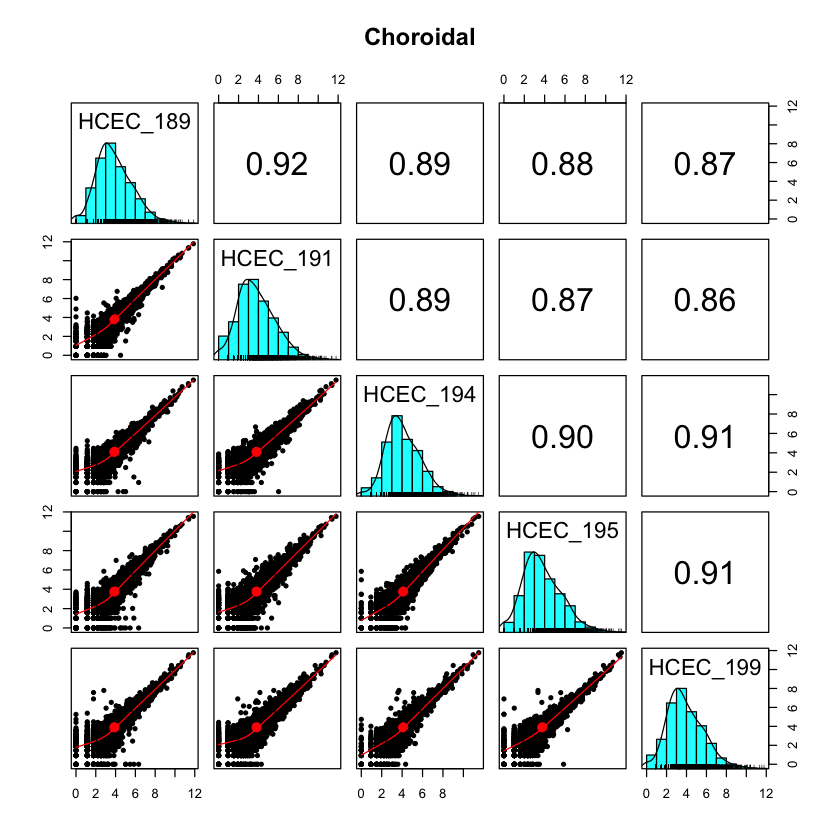

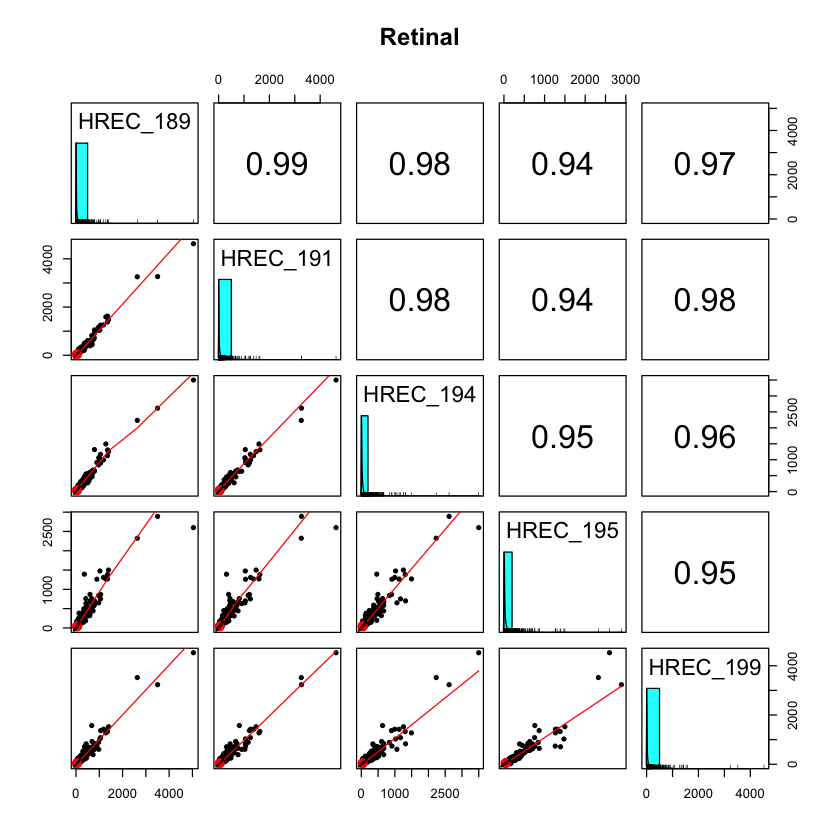

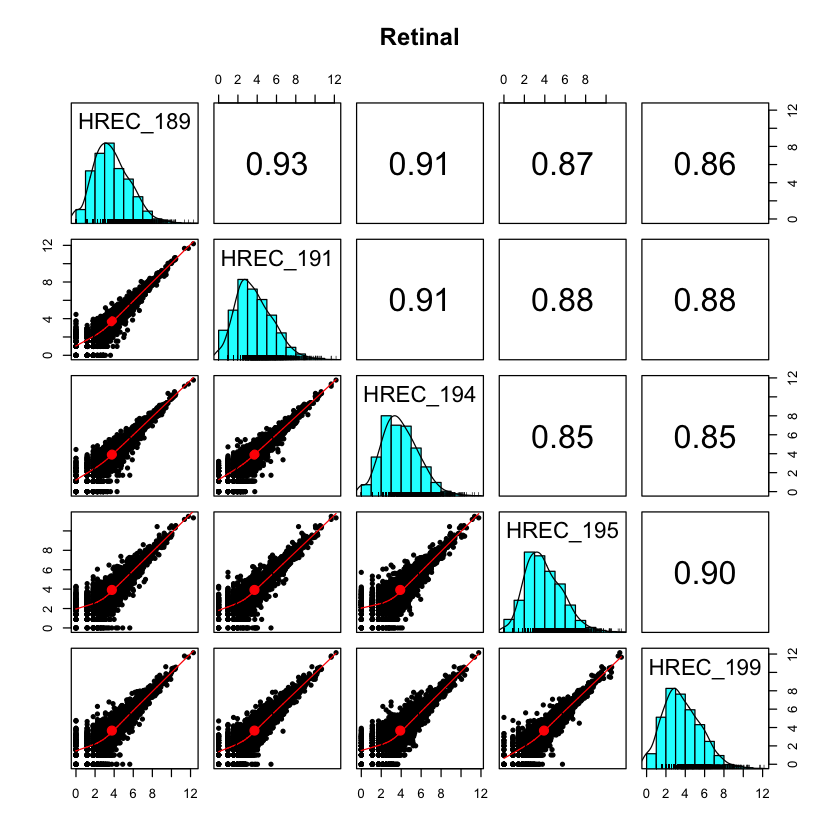

In [6]:
# function for simple normalization
SL_Norm <- function(df, color = NULL, plot = TRUE) {
    # This makes each channel sum to the average grand total
        # df - data frame of TMT intensities
        # returns a new data frame with normalized values
    
    # compute scaling factors to make colsums match the average sum
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    cat("SL Factors:\n", sprintf("%-5s -> %f\n", colnames(df), norm_facs))
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_sl + 1), col = color, notch = TRUE, main = "SL Normalized data")
    }
    df_sl
}

# normalize the data before plotting
color <- c(rep('blue', 5), rep('red', 5))
paw_sl <- SL_Norm(paw_spc, color)

# shortcuts for the cell types
C <- 1:5
R <- 6:10

pairs.panels(paw_sl[C], main = "Choroidal")
pairs.panels(log2(paw_sl[C]+1), main = "Choroidal")
pairs.panels(paw_sl[R], main = "Retinal")
pairs.panels(log2(paw_sl[R]+1), main = "Retinal")

## Spectral counting is not real precise
The linear plots are not too informative. The log plots indicate considerable sample-to-sample scatter. These experiments have about 40 SCX fractions run in 2-hour RP gradients. That is a lot of instrument time per sample. We will need pretty large differences in means to achieve statistical significance given the sample-to-sample variances.

---

# We can get started with edgeR testing

We will use the counts and accessions that we created in R above from the main summary file and load data into some edgeR data structures. We will run the built-in TMM normalization **(Ref-4)** and see if the samples have any structure in a clustering plot.

> **4.** Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

Overall Factors (lib.size+TMM):
 HCEC_189 -> 1.168534
 HCEC_191 -> 0.930945
 HCEC_194 -> 0.792689
 HCEC_195 -> 1.078526
 HCEC_199 -> 0.877565
 HREC_189 -> 1.283733
 HREC_191 -> 1.045656
 HREC_194 -> 1.080556
 HREC_195 -> 0.827676
 HREC_199 -> 1.106263


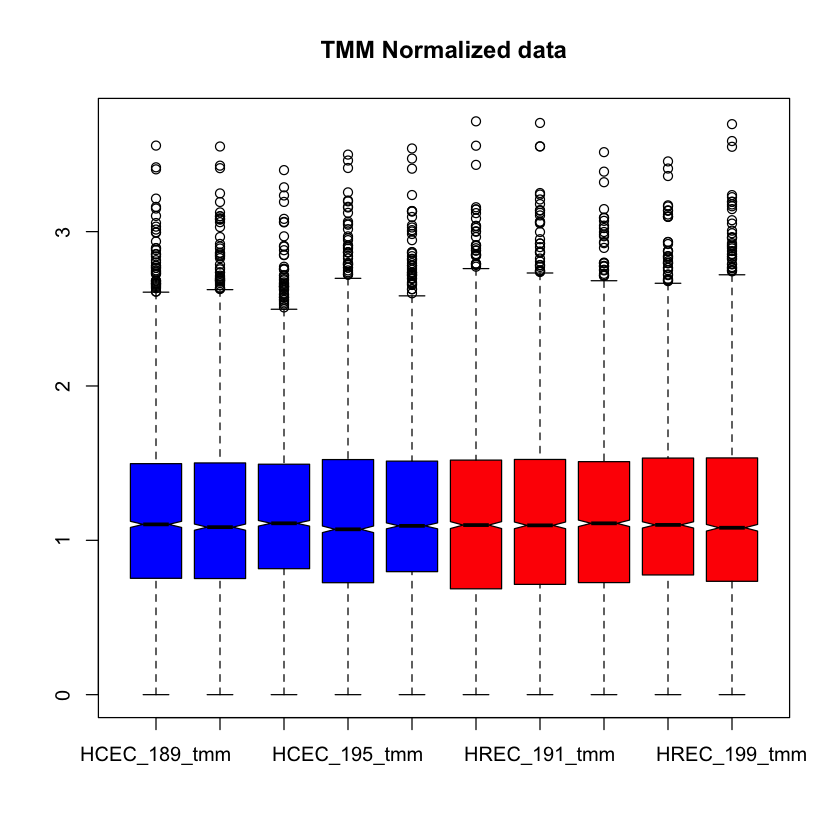

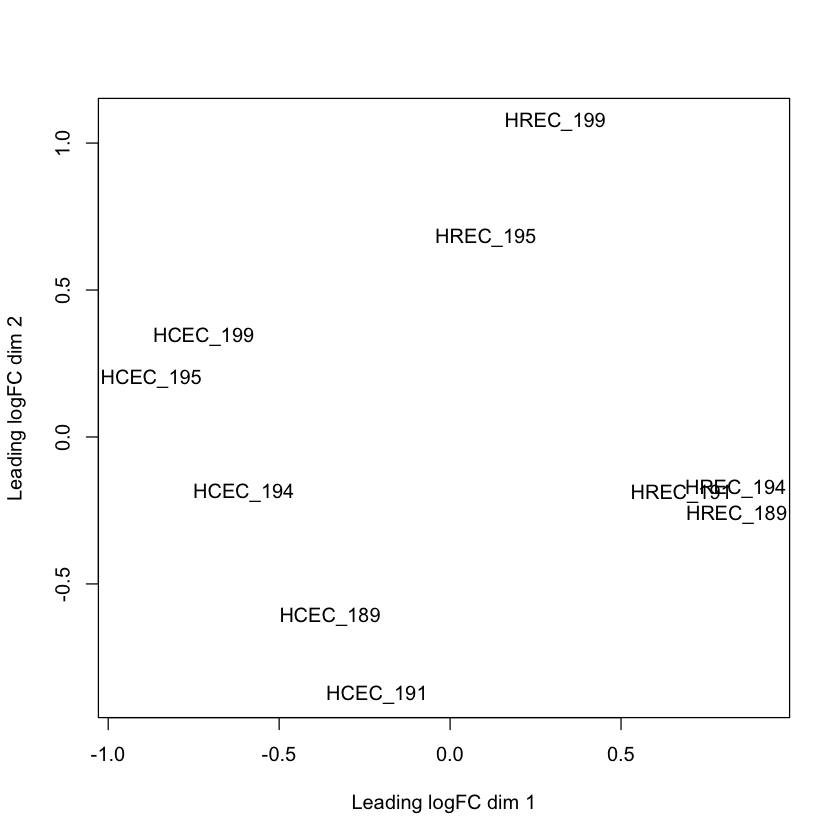

In [7]:
# load the data into edgeR data structures
# group labels need to be factors
y <- DGEList(counts = paw_spc, genes = accession)

# run the TMM normalization (and library size corrections)
y <- calcNormFactors(y)

apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    df_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(df_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_tmm + 1), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    df_tmm
}

paw_spc_tmm <- apply_tmm_factors(y, color)

# check clustering (6 different out of 1748 may not do much)
plotMDS(y)

## Clustering has left-to-right separation between choroidal and retinal cells

The overall normalization factors (library size plus TMM factors) were all pretty close to 1.0. The centers of the boxplots are pretty well aligned. TMM is more of a center of the distribution matching method, so we might expect that medians of the distributions would end up reasonably well matched.

## Can also see how normalization affected CV distributions

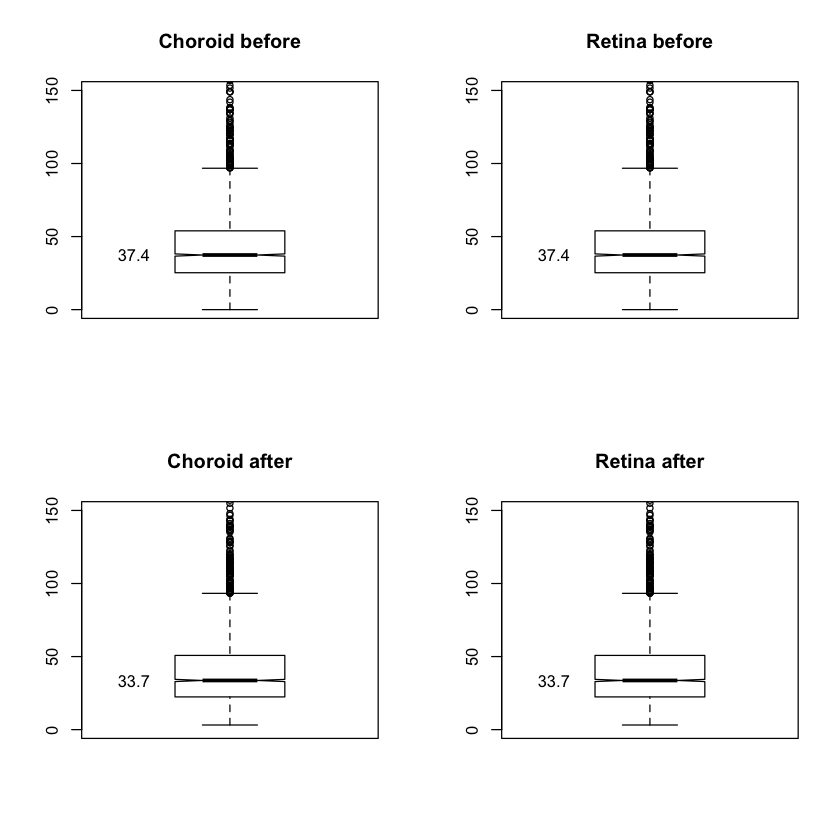

In [8]:
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

# see what effect TMM had on CV distributions
par(mfrow = c(2, 2))
labeled_boxplot(paw_spc[C], 150, "Choroid before")
labeled_boxplot(paw_spc[C], 150, "Retina before")
labeled_boxplot(paw_spc_tmm[C], 150, "Choroid after")
labeled_boxplot(paw_spc_tmm[C], 150, "Retina after")
par(mfrow = c(1, 1))

These low 30% CV for a technique like spectral counting for human subjects give some ballpark for comparison to newer methods. 

---

### ASIDE: try non-paired test for fun...

We will do a basic exact test in edgeR comparing choroidal to retinal cells (ignoring the paired nature of the study). We have a modest number of DE candidates (121 down and 181 up).

In [9]:
group <- factor(c(rep("C", 5), rep("R", 5)))
yy <-  DGEList(counts = paw_spc, group = group, genes = accession)
yy <- calcNormFactors(yy)
yy <- estimateDisp(yy)
et <- exactTest(yy)
topTags(et)$table
summary(decideTests(et, p.value = 0.10))

Design matrix not provided. Switch to the classic mode.


,genes,logFC,logCPM,PValue,FDR
312,sp|P20591|MX1_HUMAN,6.406989,9.326303,1.344724e-43,4.644676e-40
533,sp|P00352|AL1A1_HUMAN,-7.573848,8.630356,4.616319e-33,7.972384e-30
1406,sp|Q16799|RTN1_HUMAN,8.072550,7.066093,1.247038e-28,1.435757e-25
864,sp|Q12797|ASPH_HUMAN,3.016845,7.989154,6.499063e-23,5.611941e-20
1348,sp|Q14766|LTBP1_HUMAN,4.384216,7.140219,5.071970e-19,3.503717e-16
254,sp|Q92626|PXDN_HUMAN,1.797012,9.555480,2.962647e-17,1.705497e-14
2454,sp|Q5EBM0|CMPK2_HUMAN,6.632700,5.848110,4.692311e-14,2.315320e-11
1466,sp|Q53EP0|FND3B_HUMAN,2.571400,6.976194,8.960200e-14,3.868566e-11
2034,sp|P09914|IFIT1_HUMAN,5.164896,6.293081,1.488682e-13,5.713230e-11
2310,sp|O14879|IFIT3_HUMAN,4.809635,6.012322,1.801410e-12,6.222069e-10


        R-C
Down    121
NotSig 3152
Up      181

---

## Set up design matrix for paired study

EdgeR can do more complicated paired study designs if we use the linear modeling options. The edgeR [user's guide](https://www.bioconductor.org/packages/devel/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf) has several examples to use as templates. We will be mostly using Example 4.1 but with a switch to the quasi-likelihood versions of function instead of the likelihood ratio ones. The QL framework (example 4.4) is perhaps more conservative. These test options have some differences in the numbers of candidates and the magnitudes of p-values computed under different models.

The glm tests require experimental design matrices and contrasts. limma has some functions to help set those up. We will need samples categorized by donor and by cell type. The modeling will allow multiple tests to be made controlling for different factors. The paired test is basically comparing choroidal versus retinal controlling for donor. 

In [10]:
# create the experimental design matrix
donor <- factor(rep(c(189, 191, 194, 195, 199), 2))
cell <- factor(c(rep("C", 5), rep("R", 5)))

# Example 4.1 in edgeR user's guide
design <- model.matrix(~donor+cell)
rownames(design) <- colnames(y)
design

,(Intercept),donor191,donor194,donor195,donor199,cellR
HCEC_189,1,0,0,0,0,0
HCEC_191,1,1,0,0,0,0
HCEC_194,1,0,1,0,0,0
HCEC_195,1,0,0,1,0,0
HCEC_199,1,0,0,0,1,0
HREC_189,1,0,0,0,0,1
HREC_191,1,1,0,0,0,1
HREC_194,1,0,1,0,0,1
HREC_195,1,0,0,1,0,1
HREC_199,1,0,0,0,1,1


[1] 0.01457263

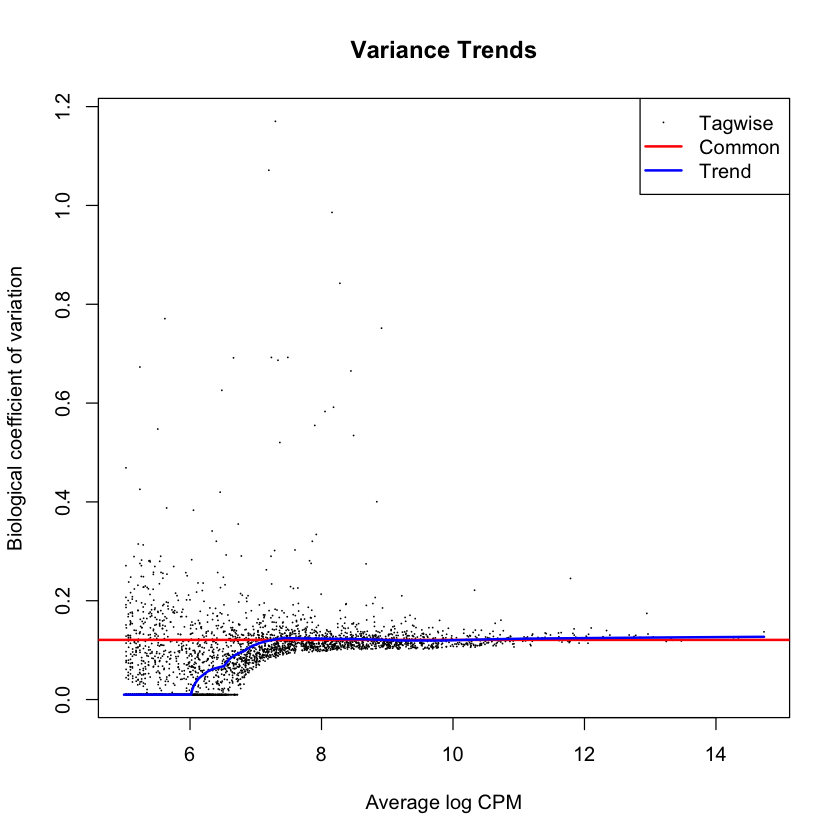

In [11]:
# extimate the dispersion parameters and check
y <- estimateDisp(y, design, robust = TRUE)
y$common.dispersion
plotBCV(y, main = "Variance Trends")

### There are more dispersion checks after the QL modeling has been done

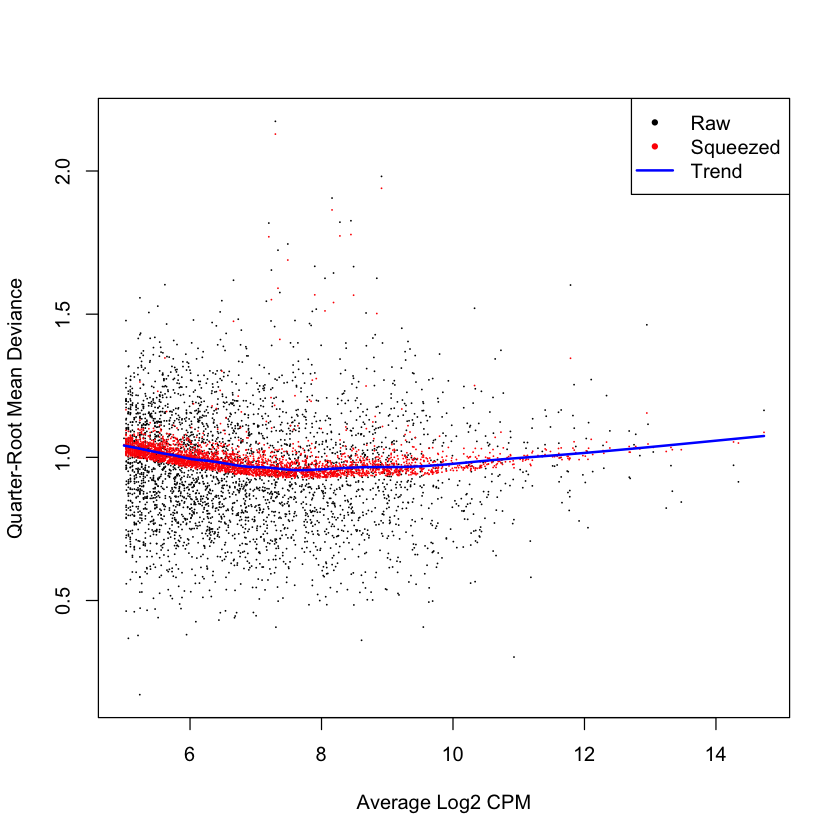

In [12]:
# fit statistical models (design matrix already in y$design)
fit <- glmQLFit(y, design, robust = TRUE)
plotQLDisp(fit)

In [13]:
# if we do not specify a contrast, the default is the last column
# of the design matrix - a C versus R comparison
paired <- glmQLFTest(fit) # default comparison

# check test results
topTags(paired)
tt <- topTags(paired, n = Inf, sort.by = "none")$table
summary(decideTests(paired, p.value = 0.10))

,genes,logFC,logCPM,F,PValue,FDR
533,sp|P00352|AL1A1_HUMAN,-7.667110,8.651386,494.0805,9.205467e-21,3.179568e-17
864,sp|Q12797|ASPH_HUMAN,3.017440,7.960610,212.6452,1.601009e-15,2.764942e-12
1406,sp|Q16799|RTN1_HUMAN,8.031352,7.053481,230.5870,7.396518e-15,8.515858e-12
254,sp|Q92626|PXDN_HUMAN,1.818821,9.544250,171.1878,3.013074e-14,2.601790e-11
312,sp|P20591|MX1_HUMAN,6.430887,9.315547,401.3743,4.502522e-14,2.741758e-11
1348,sp|Q14766|LTBP1_HUMAN,4.358365,7.129367,165.3920,4.762752e-14,2.741758e-11
693,sp|O00468|AGRIN_HUMAN,2.263501,8.326636,141.0916,3.813072e-13,1.881479e-10
294,sp|Q63HN8|RN213_HUMAN,1.800556,9.369372,127.9527,1.605397e-12,6.199916e-10
2034,sp|P09914|IFIT1_HUMAN,5.242839,6.265716,126.0255,1.615496e-12,6.199916e-10
366,sp|Q9Y3Z3|SAMH1_HUMAN,1.624241,9.136414,120.8519,2.739599e-12,9.462577e-10


       cellR
Down     255
NotSig  2883
Up       316

## We need to reformat and visualize results

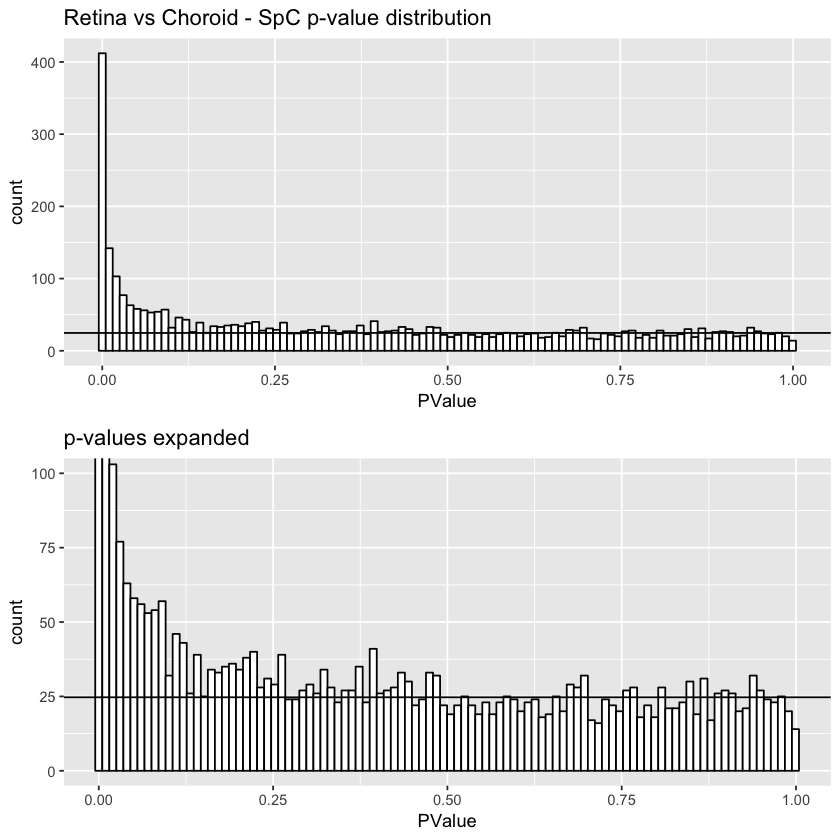

In [14]:
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# get the results summary
results <- collect_results(paw_spc_tmm, tt, C, "choroid", R, "retina")

pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# check the p-value distribution
pvalue_plots(results, 100, "Retina vs Choroid - SpC")

### P-value distribution looks nice

We have a flat distribution at larger p-values and a spike at low p-values. We can see what the fold changes look like for the different levels of DE candidates and count candidates.

candidate,n
high,272
med,166
low,133
no,2883


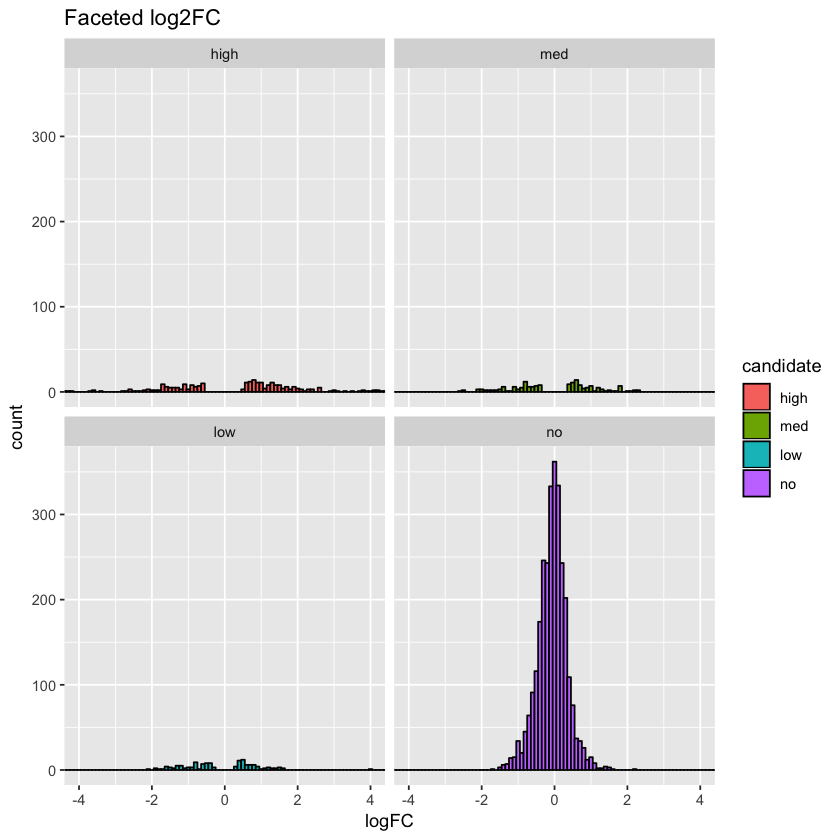

In [15]:
log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# make log2FC plots
log2FC_plots(results, 4, "Faceted log2FC")

# see how many candidates are in each category
results %>% count(candidate)

### We need to visualize the DE candidates (and non-candidates)

We will make:
- MA plots
- Scatter plots
- A volcano plot

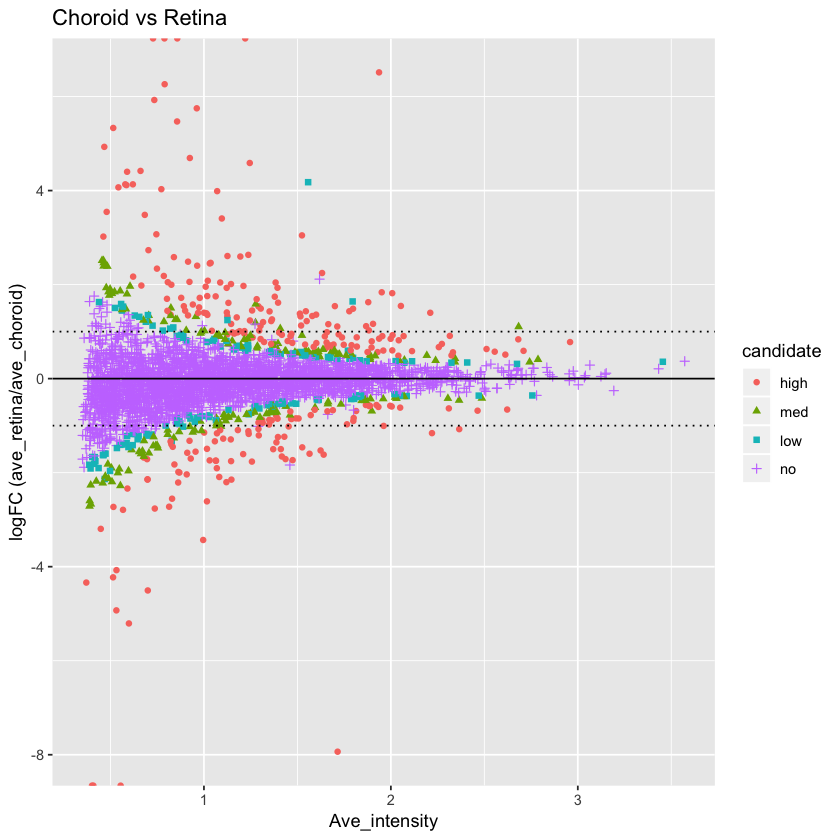

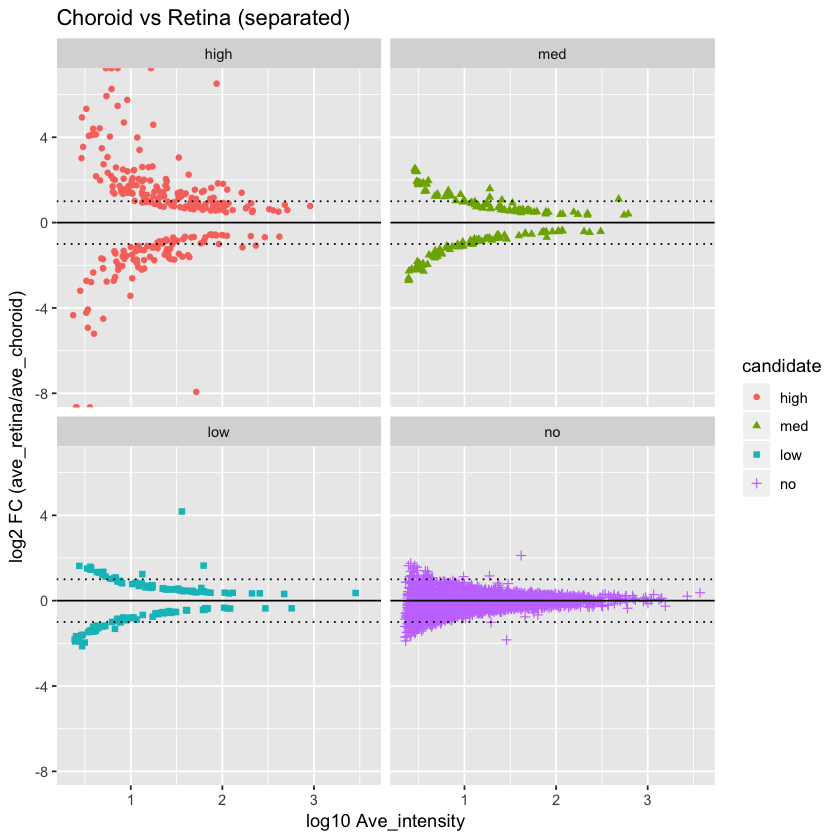

In [16]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# make MA plots
MA_plots(results, "ave_choroid", "ave_retina", "Choroid vs Retina")

## edgeR robustly models the wider dispersion at low spectral counts

---

# REALLY IMPORTANT ASIDE

The spectral count values have been maintained in their natural measurement scale. That means that they are actual counts that have a Poisson distribution. EdgeR models that correctly so that the large uncertainty in small count numbers does not result in large numbers of false positive DE candidates. 

There are other commonly used transformations of spectral count data where this is not the case. Samples can be normalized to have all counts sum up to one by dividing each column by its total. That makes the measurement values be small fractions between 0.0 and 1.0. Taking logs of counts would also alter the natural measurement scale and change the mean-variance relationship. There can also be protein length correction (dividing by length or number of theoretical peptides) of counts to make relative abundances more like molar concentrations instead of weight percentages. Those have the effect of somewhat local scrambling of abundances and it disrupts the smooth dispersion trend making trended variance estimates less effective.

The bottom line is that just about anything you would do transformation-wise to spectral counts will hurt the data analysis. This is also likely true in other quantitative measures beside spectral counting. Determining a natural measurement scale is very important for data modeling. Do not arbitrarily transform data.

One more soap box moment. Often the distribution of all of the protein measures are examined and they typically have skewed distributions. Taking the logs of the measures can make the distributions appear more normally distributed (as taking logs does for just about anything). Arguments are made that this is appropriate when using a t-test. That is incorrect. The t-test is being applied to a single protein. It is the distribution of the measures of that particular protein that should be normally distributed, not the distribution of different proteins relative to each other in the whole dataset. We always have too few data points (the number of biological replicates) to say much of anything about whether individual protein measures are normally distributed. It can be a good thing to understand what a model is actually modeling.

---

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”

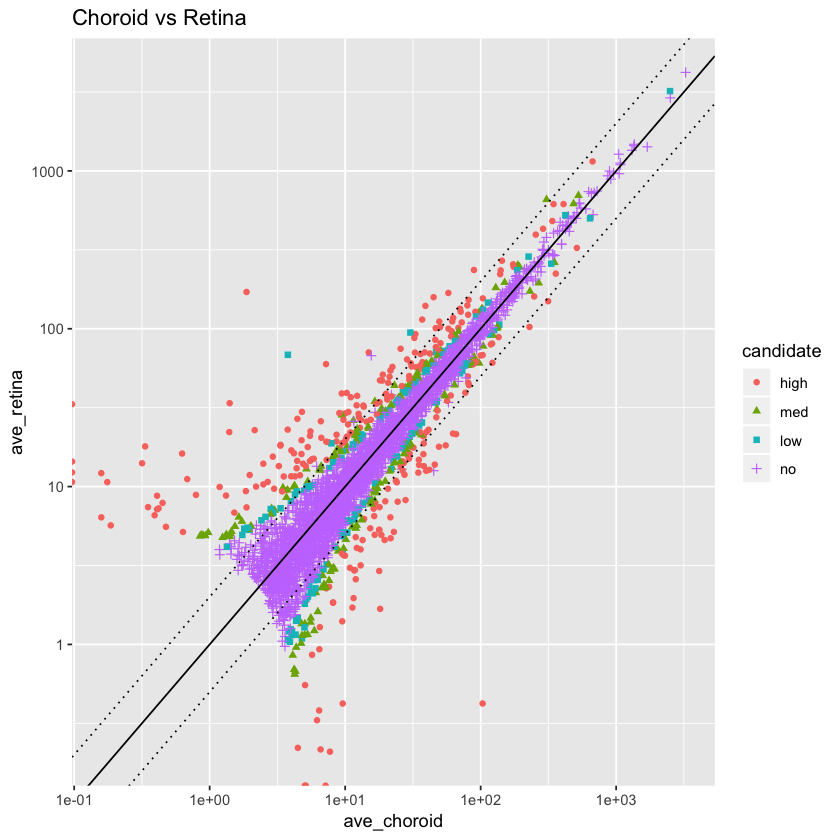

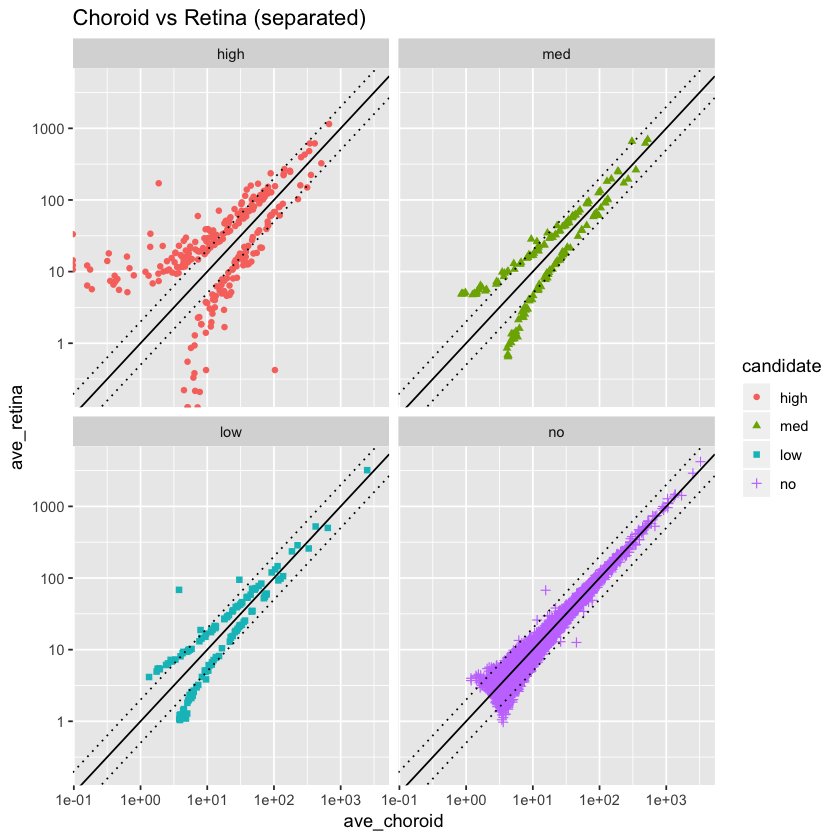

In [17]:
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# make scatter plots
scatter_plots(results, "ave_choroid", "ave_retina", "Choroid vs Retina")

### We have some zeros in the average count vectors...

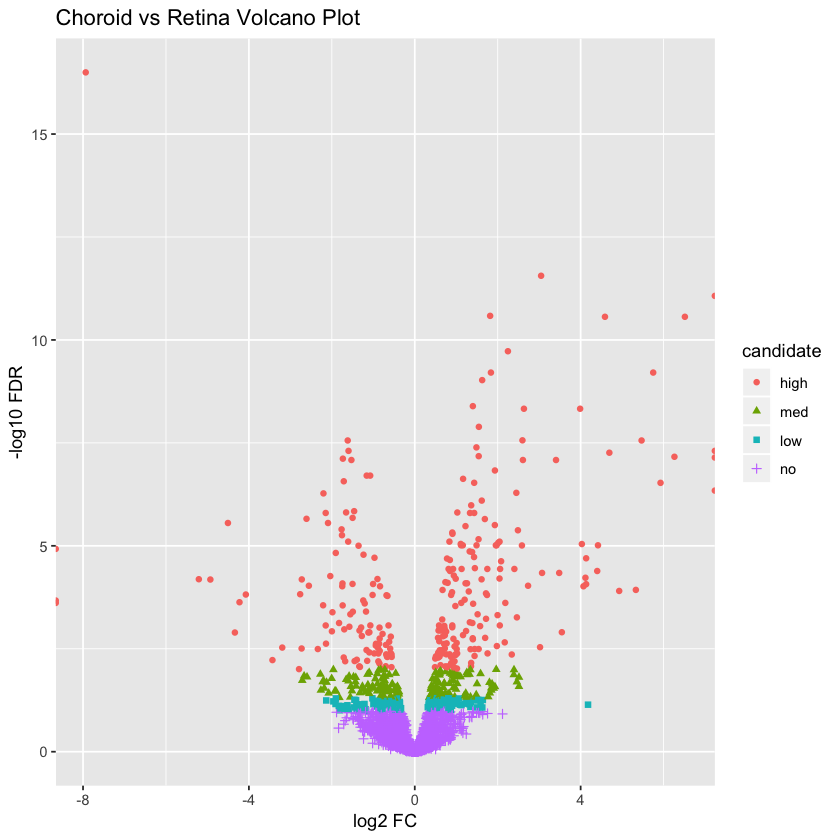

In [18]:
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# make a volcano plot
volcano_plot(results, "ave_choroid", "ave_retina", "Choroid vs Retina")

### The DE candidates look convincing in all of the plot types

## Save the results and log the session

Save results data frame to a disk file and log the R session. Generating the DE candidates is one of the earlier steps in the analysis and interpretation. Adding annotations, functional enrichment analysis, pathway analysis, and more are needed to extract the biological meaning from the data. The results table should be easy to add back to the main proteomics table before the next analysis steps.

In [19]:
# write results
write.table(results, "edgeR_results.txt", sep = "\t", row.names = FALSE, na = " ")

# log the session
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.3

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.0.0    gridExtra_2.3   psych_1.8.12    edgeR_3.24.3   
 [5] limma_3.38.3    forcats_0.3.0   stringr_1.3.1   dplyr_0.7.8    
 [9] purrr_0.3.0     readr_1.3.1     tidyr_0.8.2     tibble_2.0.1   
[13] ggplot2_3.1.0   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     statmod_1.4.30   locfit_1.5-9.1   tidyselect_0.2.5
 [5] repr_0.19.1      splines_3.5.0    haven_2.0.0      lattice_0.20-38 
 [9] colorspace_1.4-0 generics_0.0.2   htmltools_0.3.6  base64enc_0.1-